In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 
from basic_finance_tools import get_or_download_data, plot_df

warnings.filterwarnings("ignore")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

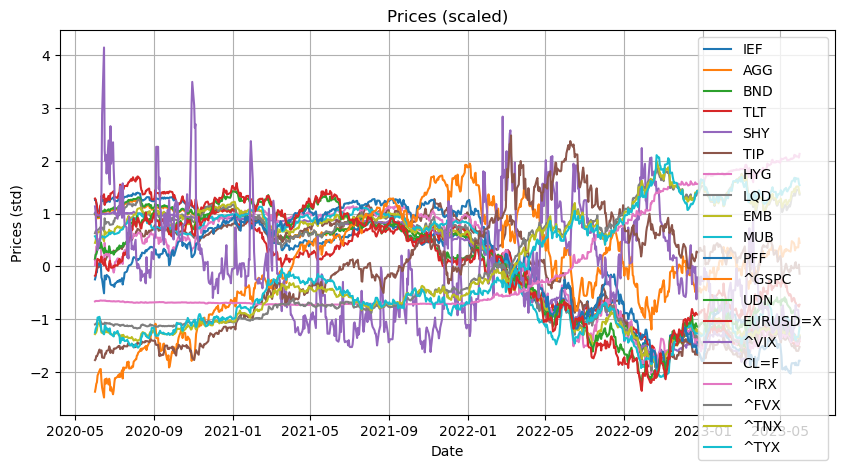

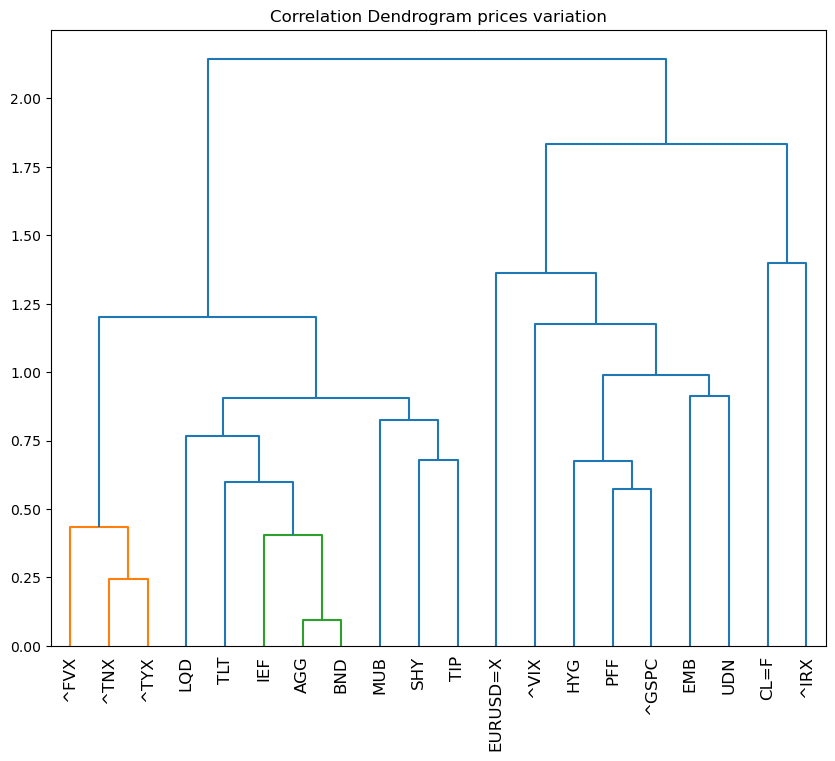

In [2]:
# In this cell, historical price data for various assets are retrieved and analyzed 
# to identify correlations between them. Using hierarchical clustering on these 
# correlations, the cell aims to select suitable ticker pairs for pair trading, 
# a strategy that exploits price relationships between highly correlated assets.


# Ticklers list for pair trading strategy across various sectors
#tickers_for_selection  = tickers_como = ['HG=F', 'CL=F', 'BZ=F', 'NG=F', 'RB=F', 'HO=F', 'CC=F', 'ZW=F', 'ZC=F', 'ZS=F', 'CT=F', 'CC', 'KC', 'SB', 'GF=F', 'GC=F', 'SI=F', 'PL=F', 'PA=F', 'ZN=F', 'ZB=F']
tickers_for_selection = tickers_bond = ['IEF', 'AGG', 'BND', 'TLT', 'SHY', 'TIP', 'HYG', 'LQD',  'EMB', 'MUB', 'PFF', '^GSPC', 'TIP', '^GSPC', 'LQD', 'UDN', 'EURUSD=X', '^VIX', 'CL=F', '^IRX', '^FVX', '^TNX', '^TYX']


# Downloading price data for the selected tickers
prices_df_for_selection = get_or_download_data(tickers_for_selection, start_date='2020-06-01', end_date='2023-06-01')

# Plotting scaled prices for analysis
plot_df(prices_df_for_selection, title='Prices', unit='(USD)', scaled=True)

# Hierarchical clustering to identify correlated tickers for pair trading
from scipy.cluster import hierarchy
import numpy as np
import matplotlib.pyplot as plt

def plot_correlation_dendrogram(df:pd.DataFrame, title:str):
    corr_matrix = df.corr()  # Correlation matrix
    distance_matrix = 1 - np.abs(corr_matrix)  # Distance matrix
    linkage = hierarchy.linkage(distance_matrix, method='average')  # Hierarchical clustering
    plt.figure(figsize=(10, 8))
    hierarchy.dendrogram(linkage, labels=df.columns, orientation='top', color_threshold=0.5)  # Dendrogram plot
    plt.title(f'Correlation Dendrogram {title}')
    plt.xticks(rotation=90)
    plt.show()

# Plotting the dendrogram for price variations
plot_correlation_dendrogram(prices_df_for_selection.pct_change(), 'prices variation')


In [3]:
tickers = ['CL=F','BZ=F'] #Oil cracks
tickers = ['IEF', 'AGG',] #US treasury bonds different maturities

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


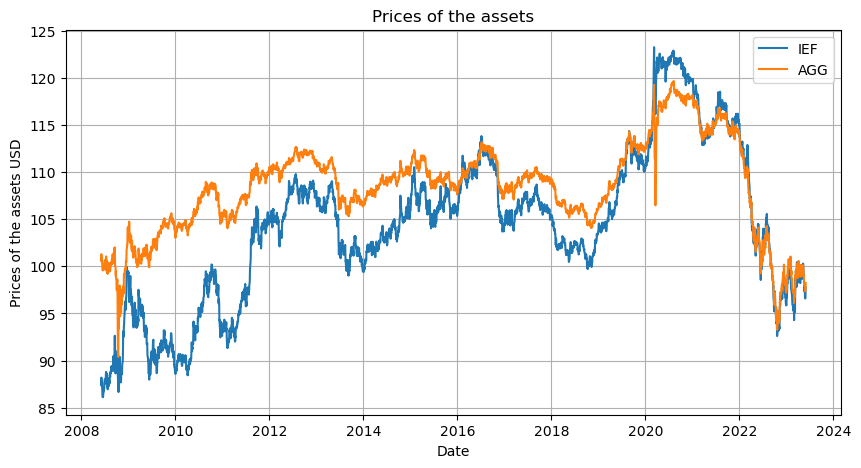

In [4]:
# Specify the date range for data download
start = '2008-06-01'
end = '2023-06-01'

prices_data = get_or_download_data(tickers, start_date = start, end_date = end)
prices_data = prices_data.resample('1B').ffill().ffill().fillna(0)
plot_df(prices_data, title= 'Prices of the assets', unit='USD')

In [5]:
from basic_finance_tools import moving_Zscore

def compute_signal_PT(prices: pd.DataFrame, wz1: int, wz2:int =0)->pd.DataFrame:
    tickers = prices.columns

    # Create a signal based on the difference of the prices zscore if wz1 != 0, by the difference of the prices if wz1=0
    signal = pd.DataFrame(index=prices.index, columns=tickers)
    signal[tickers[0]] = - (moving_Zscore(prices[tickers[0]], window_size_zs=wz1) - moving_Zscore(prices[tickers[1]], window_size_zs=wz1))
    signal[tickers[1]] = - signal[tickers[0]]

    # If wz2 is specified, take the moving Z-Score of the computed signal as final signal
    if wz2: signal = moving_Zscore(signal, wz2)

    return signal


In [6]:
from basic_finance_tools import moving_Zscore, compute_position, compute_PNL, compute_metrics, plot_ds_hue

def show_strat_pairtrading(prices: pd.DataFrame, wz1: int, wz2:int =0) -> None:
    """
    Demonstrates a trading strategy based on moving Z-scores and visualizes the results.

    Parameters:
    - prices (pd.DataFrame): DataFrame containing asset prices.
    - wz1 (int): Window size for short-term Z-score calculation.
    - wz2 (int): Window size for long-term Z-score calculation.
    """
    tickers = prices.columns

    # Create a signal based on the difference 
    signal = compute_signal_PT(prices, wz1, wz2)

    # Compute positions: if the signal is above a threshold, use it to scale the price; otherwise, position is 0
    positions = compute_position(signal, prices, threshold=0)

    # Compute PnL: daily profit or loss based on the price changes and previous day's positions
    pnl = compute_PNL(positions, prices)

    # Compute and display key performance metrics (Sharpe ratio, turnover, basis points, etc.)
    metrics = compute_metrics(pnl, positions)
    print(metrics)

    # Plot daily PnL against the average absolute signal strength
    plot_ds_hue(pnl['DAILY'], signal.abs().mean(axis=1), title="PNL")

{'sharpe_ratio': 0.19, 'turnover': 42.9, 'bips': 1.0, 'effective_sharpe_ratio': 0.19, 'eff_turnover': 43.22}


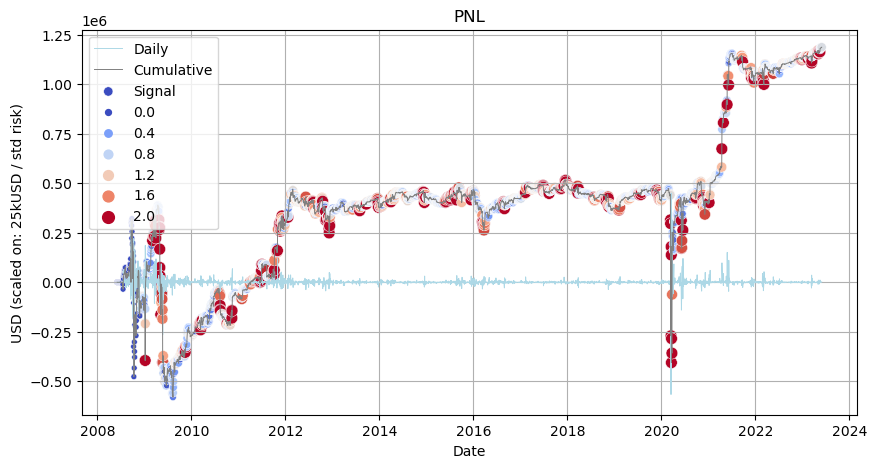

{'sharpe_ratio': 0.4, 'turnover': 66.5, 'bips': 1.3, 'effective_sharpe_ratio': 0.4, 'eff_turnover': 66.62}


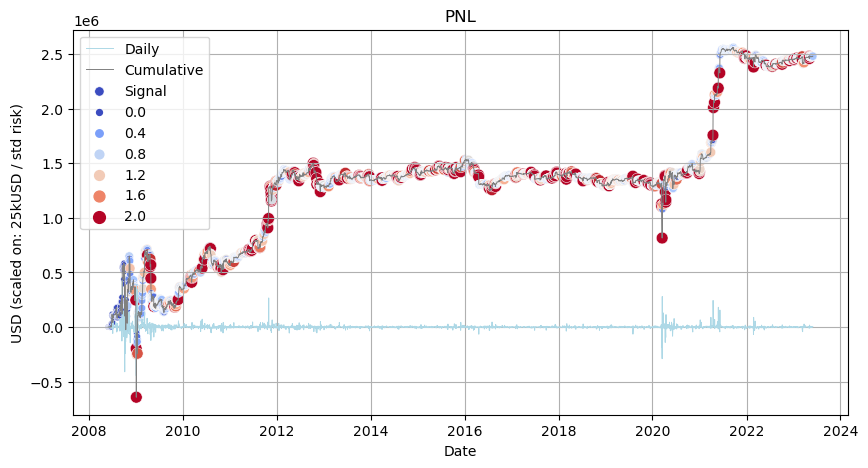

{'sharpe_ratio': 0.57, 'turnover': 66.7, 'bips': 0.9, 'effective_sharpe_ratio': 0.57, 'eff_turnover': 67.0}


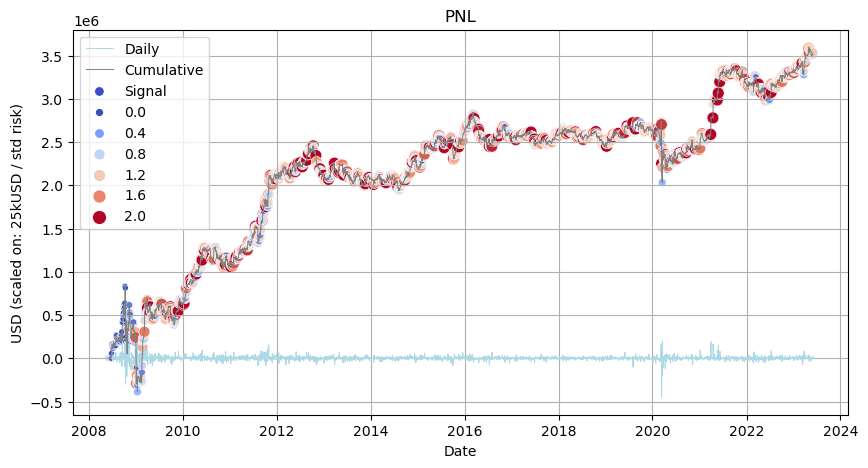

In [7]:
prices = prices_data.copy()
show_strat_pairtrading(prices,wz1=30)
show_strat_pairtrading(prices,wz1=10)
show_strat_pairtrading(prices,wz1=10, wz2=10)

# 3 different trajectory of the PnL using 2 different parameters set

wz1 [0, 3, 6, 9, 13, 16, 19, 23, 26, 30]
wz2 [0, 3, 6, 9, 13, 16, 19, 23, 26, 30]
Best Parameters: {'wz1': 3, 'wz2': 6} Best Result: 0.9


{'sharpe_ratio': 0.9, 'turnover': 81.4, 'bips': 1.2, 'effective_sharpe_ratio': 0.9, 'eff_turnover': 81.58}


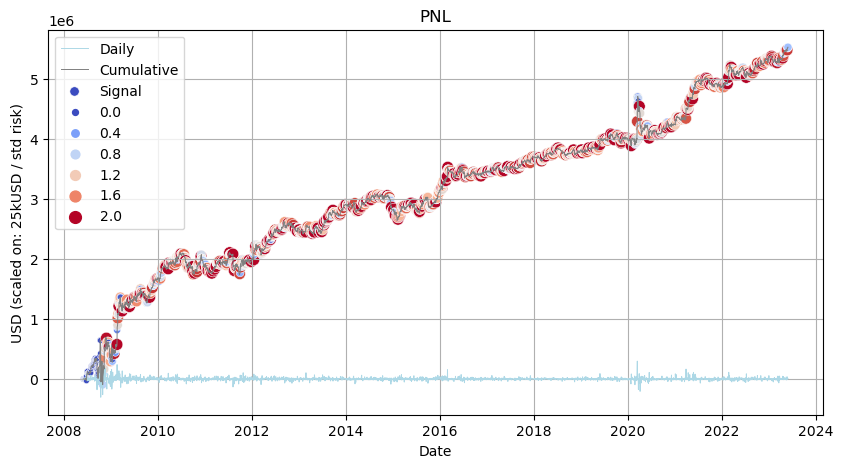

In [8]:
# Grid search optimization for wz1, wz2, wvt parameters for zscore strat
from basic_finance_tools import grid_search

def evaluate_PairTrading_strat(wz1: int, wz2:int) -> float:
    # Strategy evaluation using Z-Score
    global prices

    signal = compute_signal_PT(prices, wz1, wz2)
    positions = compute_position(signal, prices)
    pnl = compute_PNL(positions, prices)
    return np.abs(compute_metrics(pnl, positions)['sharpe_ratio'])

# Define parameter ranges for grid search
param_grid = {
    'wz1': [0] + np.linspace(3, 30, 9, dtype=int).tolist(),
    'wz2': [0] + np.linspace(3, 30, 9, dtype=int).tolist(),
}

# Print parameter ranges for verification
for key, value in param_grid.items(): print(key, value)

# Perform grid search and print best parameters and result
best_params, best_result = grid_search(evaluate_PairTrading_strat, param_grid)
print("Best Parameters:", best_params, "Best Result:", best_result)
print("\n")

# Visualize strategy using the best parameters
show_strat_pairtrading(prices, **best_params)

# With gridsearch, it hard to determine if we have been lucky and have picked a 
# good trajectory among N, which would be similar to overfitting, or if we have 
# correctly calibrate the parameters of the model

{'wz1': 0, 'wz2': 3} 0.61
{'wz1': 3, 'wz2': 6} 0.9
{'wz1': 6, 'wz2': 9} 0.85
{'wz1': 9, 'wz2': 3} 0.77
{'wz1': 13, 'wz2': 3} 0.7
{'wz1': 16, 'wz2': 6} 0.67
{'wz1': 19, 'wz2': 3} 0.76
{'wz1': 23, 'wz2': 3} 0.58
{'wz1': 26, 'wz2': 3} 0.65
{'wz1': 30, 'wz2': 3} 0.66


<Axes: title={'center': 'param_1 -> max(sharpe(param_1, param_2, ..., param_n) for param_2, ..., param_n in grid)'}, xlabel='wz1', ylabel='sharpe'>

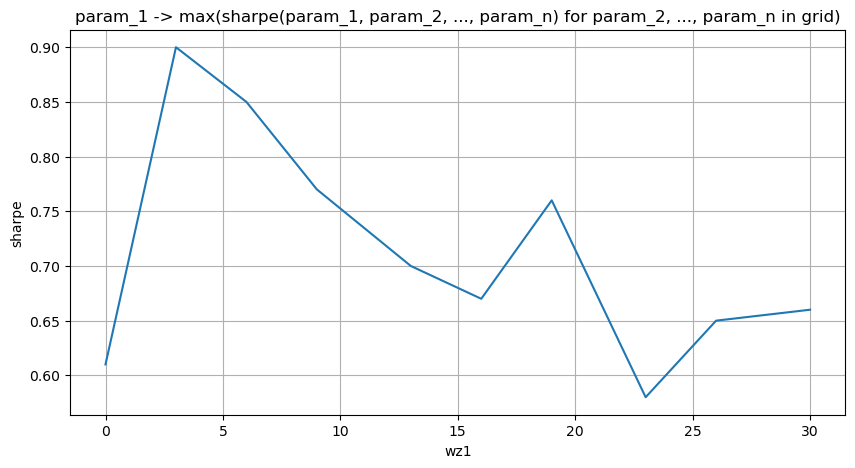

In [9]:
#Vizualise param_1 -> max(sharpe(param_1, param_2, ..., param_n) for param_2, ..., param_n in grid)
import matplotlib.pyplot as plt
import seaborn as sns 

param_selected = 'wz1'
param_1_values = param_grid[param_selected]

param_grid_cut = {key: val for key, val in param_grid.items() if key != param_selected}

result_values = []
for param_1 in param_1_values:
    best_params, best_result = grid_search(evaluate_PairTrading_strat, {**{param_selected:[param_1]}, **param_grid_cut,})
    result_values.append(best_result)
    print(best_params, best_result, )

df = pd.DataFrame({
    param_selected: param_1_values,
    'sharpe': result_values
})

plt.figure(figsize=(10, 5))
plt.title('param_1 -> max(sharpe(param_1, param_2, ..., param_n) for param_2, ..., param_n in grid)')
plt.grid()
sns.lineplot(x=param_selected, y='sharpe', data=df)